In [1]:

%pprint
import sys
if (osp.join(os.pardir, 'py') not in sys.path): sys.path.insert(1, osp.join(os.pardir, 'py'))

Pretty printing has been turned OFF


In [2]:

from FRVRS import (DataFrame, nu, re, np, nan, NaT, concat, display)
import os
import pandas as pd
import matplotlib.pyplot as plt


# Elapsed Time Estimation for Operations

In [4]:

# Get all CSVs into one data frame
frvrs_logs_df = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df')['frvrs_logs_df']
print(frvrs_logs_df.shape)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Argument 'placement' has incorrect type (expected pandas._libs.internals.BlockPlacement, got slice)
No pickle exists for frvrs_logs_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/frvrs_logs_df.csv.
(829116, 114)



## Operations

Here are the operations for which we could use a better estimate for elapsed time that we can use for ADM actions:

- apply tourniquet
- apply pressure bandage
- apply hemostatic gauze
- apply decompression needle
- apply nasopharyngeal airway
- tag a casualty
- check pulse
- direct mobile casualties (walkers check)
- wavers check.

In [4]:

# List the action types
frvrs_logs_df.action_type.value_counts().sort_index()

action_type
BAG_ACCESS              2180
BAG_CLOSED              2149
INJURY_RECORD           3052
INJURY_TREATED          1577
PATIENT_DEMOTED         1818
PATIENT_ENGAGED         2295
PATIENT_RECORD          2063
PULSE_TAKEN             3427
SESSION_END              256
SESSION_START            266
S_A_L_T_WALKED          2725
S_A_L_T_WALK_IF_CAN     4567
S_A_L_T_WAVED           1761
S_A_L_T_WAVE_IF_CAN     2147
TAG_APPLIED             1819
TAG_DISCARDED            533
TAG_SELECTED            2353
TELEPORT                5678
TOOL_APPLIED            1818
TOOL_DISCARDED          1655
TOOL_HOVER             89733
TOOL_SELECTED           2263
VOICE_CAPTURE          10115
VOICE_COMMAND           2916
Name: count, dtype: int64

In [5]:

frvrs_logs_df.tool_applied_type.unique().tolist()

[nan, 'Needle', 'Tourniquet', 'Gauze_Pack', 'Gauze_Dressing']


These action types mean that the DM has made a decision: INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, TAG_APPLIED, and TOOL_APPLIED.

In [7]:

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [8]:

# Apply some tool
def show_action_consequents(tool_mask_series, action_type='TOOL_APPLIED', voice_command_message=None, verbose=False):
    """
    Show the consequents of the given action type.

    Parameters
    ----------
    tool_mask_series : Series
        The type of filter to apply to fu.get_session_groupby.
    action_type : str, optional
        The type of action to consider. Defaults to 'TOOL_APPLIED'.
    voice_command_message : str, optional
        The specific voice command. Defaults to None.

    Returns
    -------
    None

    """
    
    actions_list = []
    for (session_uuid, scene_id), df in fu.get_session_groupby(frvrs_logs_df, mask_series=tool_mask_series, extra_column='scene_id'):
        base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id)
        for row_index, row_series in df.iterrows():
            action_tick = row_series.action_tick
            mask_series = base_mask_series & (frvrs_logs_df.action_tick >= action_tick)
            df1 = frvrs_logs_df[mask_series].sort_values('action_tick')
            
            # Get the list of actions that follow the given action type
            action_types_list = []
            if df1.shape[0] > 1:
                action_types_list = df1.action_type.tolist()
                if 'INJURY_TREATED' in action_types_list: action_types_list = action_types_list[:min(7, action_types_list.index('INJURY_TREATED')+1)]
                else: action_types_list = action_types_list[:2]
            if action_types_list: actions_list.append(action_types_list)
            
            # Get the delta to the next action not happening simultaneously
            mask_series = base_mask_series & (frvrs_logs_df.action_tick > action_tick)
            if (action_type == 'VOICE_COMMAND') and (voice_command_message is not None):
                walk_wave = (voice_command_message.split()[0] + 'ed').replace('ee', 'e')
                mask_series &= frvrs_logs_df.action_type.map(lambda x: walk_wave in str(x).lower())
                # print(f"mask_series = (frvrs_logs_df.session_uuid == '{session_uuid}') & (frvrs_logs_df.scene_id == {scene_id}) & (frvrs_logs_df.action_tick > {action_tick}) & frvrs_logs_df.action_type.map(lambda x: '{walk_wave}' in str(x).lower())"); raise
            df1 = frvrs_logs_df[mask_series].sort_values('action_tick').head(1)
            if df1.shape[0]:
                frvrs_logs_df.loc[row_index, 'delta_to_next_action'] = (df1.action_tick.squeeze() - action_tick)
            else:
                frvrs_logs_df.loc[row_index, 'delta_to_next_action'] = nan
            
    if actions_list:
        
        # Create a one-hot encoded Data Frame of the actions
        te = TransactionEncoder()
        te_ary = te.fit(actions_list).transform(actions_list)
        actions_one_hot_df = DataFrame(te_ary, columns=te.columns_)
        
        # Print the actions following the given action type
        print(f'The actions following {action_type} are {nu.conjunctify_nouns(actions_one_hot_df.columns.tolist())}.')
        
        # Get the frequent itemsets and association rules
        actions_itemsets_df = apriori(
            actions_one_hot_df, min_support=0.01, use_colnames=True, max_len=50
        )
        actions_itemsets_df['itemsets_size'] = actions_itemsets_df.itemsets.map(lambda x: len(eval(str(x))))
        
        actions_rules_df = association_rules(actions_itemsets_df, metric='lift', min_threshold=0.75)
        
        # Get the consequents with the highest support for the given action type
        mask_series = (actions_rules_df.antecedents == frozenset({action_type}))
        df = actions_rules_df[mask_series].sort_values(['lift', 'consequent support'], ascending=[False, False])
        if df.head(5).shape[0]:
            print(f'Get the consequent with the highest support for {action_type.lower().replace("_", " ")}')
            display(df.head(5))

In [9]:

# Apply tourniquet
tool_mask_series = (frvrs_logs_df.action_type == 'TOOL_APPLIED') & (frvrs_logs_df.tool_applied_type == 'Tourniquet')
show_action_consequents(tool_mask_series)

The actions following TOOL_APPLIED are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_DISCARDED, TOOL_HOVER, TOOL_SELECTED, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for tool applied


antecedents      consequents  antecedent support  consequent support  \
73  (TOOL_APPLIED)  (VOICE_CAPTURE)            0.255692            0.098074   
57  (TOOL_APPLIED)   (TAG_SELECTED)            0.255692            0.094571   
36  (TOOL_APPLIED)    (PULSE_TAKEN)            0.255692            0.084063   
18  (TOOL_APPLIED)     (BAG_CLOSED)            0.255692            0.070053   
47  (TOOL_APPLIED)    (TAG_APPLIED)            0.255692            0.061296   

     support  confidence      lift  leverage  conviction  zhangs_metric  
73  0.098074    0.383562  3.910959  0.072997    1.463125            1.0  
57  0.094571    0.369863  3.910959  0.070390    1.436877            1.0  
36  0.084063    0.328767  3.910959  0.062569    1.364559            1.0  
18  0.070053    0.273973  3.910959  0.052141    1.280871            1.0  
47  0.061296    0.239726  3.910959  0.045623    1.234692            1.0

In [10]:

# apply pressure bandage
tool_mask_series = (frvrs_logs_df.action_type == 'TOOL_APPLIED') & (frvrs_logs_df.tool_applied_type == 'Gauze_Dressing')
show_action_consequents(tool_mask_series)

The actions following TOOL_APPLIED are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_DISCARDED, TOOL_HOVER, TOOL_SELECTED, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for tool applied


antecedents      consequents  antecedent support  consequent support  \
63  (TOOL_APPLIED)   (TAG_SELECTED)            0.371316            0.094303   
81  (TOOL_APPLIED)  (VOICE_CAPTURE)            0.371316            0.082515   
20  (TOOL_APPLIED)     (BAG_CLOSED)            0.371316            0.076621   
46  (TOOL_APPLIED)    (PULSE_TAKEN)            0.371316            0.076621   
69  (TOOL_APPLIED)       (TELEPORT)            0.371316            0.074656   

     support  confidence      lift  leverage  conviction  zhangs_metric  
63  0.094303    0.253968  2.693122  0.059286    1.214020            1.0  
81  0.082515    0.222222  2.693122  0.051876    1.179624            1.0  
20  0.076621    0.206349  2.693122  0.048170    1.163458            1.0  
46  0.076621    0.206349  2.693122  0.048170    1.163458            1.0  
69  0.074656    0.201058  2.693122  0.046935    1.158212            1.0

In [11]:

# apply hemostatic gauze
tool_mask_series = (frvrs_logs_df.action_type == 'TOOL_APPLIED') & (frvrs_logs_df.tool_applied_type == 'Gauze_Pack')
show_action_consequents(tool_mask_series)

The actions following TOOL_APPLIED are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, S_A_L_T_WAVED, S_A_L_T_WAVE_IF_CAN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_DISCARDED, TOOL_HOVER, TOOL_SELECTED, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for tool applied


antecedents      consequents  antecedent support  consequent support  \
63  (TOOL_APPLIED)  (VOICE_CAPTURE)            0.208247            0.080412   
53  (TOOL_APPLIED)   (TAG_SELECTED)            0.208247            0.049485   
28  (TOOL_APPLIED)    (PULSE_TAKEN)            0.208247            0.047423   
14  (TOOL_APPLIED)     (BAG_CLOSED)            0.208247            0.037113   
41  (TOOL_APPLIED)    (TAG_APPLIED)            0.208247            0.037113   

     support  confidence     lift  leverage  conviction  zhangs_metric  
63  0.080412    0.386139  4.80198  0.063667    1.498038            1.0  
53  0.049485    0.237624  4.80198  0.039180    1.246780            1.0  
28  0.047423    0.227723  4.80198  0.037547    1.233466            1.0  
14  0.037113    0.178218  4.80198  0.029385    1.171705            1.0  
41  0.037113    0.178218  4.80198  0.029385    1.171705            1.0

In [12]:

# apply decompression needle
tool_mask_series = (frvrs_logs_df.action_type == 'TOOL_APPLIED') & (frvrs_logs_df.tool_applied_type == 'Needle')
show_action_consequents(tool_mask_series)

The actions following TOOL_APPLIED are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, S_A_L_T_WALK_IF_CAN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_HOVER, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for tool applied


antecedents                    consequents  antecedent support  \
67   (TOOL_APPLIED)                 (TAG_SELECTED)            0.256917   
40   (TOOL_APPLIED)                  (PULSE_TAKEN)            0.256917   
18   (TOOL_APPLIED)                   (BAG_CLOSED)            0.256917   
467  (TOOL_APPLIED)  (TAG_SELECTED, VOICE_CAPTURE)            0.256917   
214  (TOOL_APPLIED)     (TAG_SELECTED, BAG_CLOSED)            0.256917   

     consequent support   support  confidence      lift  leverage  conviction  \
67             0.189723  0.189723    0.738462  3.892308  0.140980    3.098117   
40             0.130435  0.130435    0.507692  3.892308  0.096924    1.766304   
18             0.118577  0.118577    0.461538  3.892308  0.088113    1.636928   
467            0.118577  0.118577    0.461538  3.892308  0.088113    1.636928   
214            0.106719  0.106719    0.415385  3.892308  0.079301    1.527980   

     zhangs_metric  
67             1.0  
40             1.0  
18             1.0  
467            1.0  
214            1.0

In [13]:

# apply nasopharyngeal airway
tool_mask_series = (frvrs_logs_df.action_type == 'TOOL_APPLIED') & (frvrs_logs_df.tool_applied_type == 'Nasopharyngeal_Airway')
show_action_consequents(tool_mask_series)

In [14]:

# tag a casualty
action_type = 'TAG_APPLIED'
tool_mask_series = (frvrs_logs_df.action_type == action_type)
show_action_consequents(tool_mask_series, action_type=action_type)

The actions following TAG_APPLIED are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, SESSION_END, S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVED, S_A_L_T_WAVE_IF_CAN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_DISCARDED, TOOL_HOVER, TOOL_SELECTED, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for tag applied


antecedents             consequents  antecedent support  \
22   (TAG_APPLIED)            (BAG_CLOSED)                 1.0   
78   (TAG_APPLIED)              (TELEPORT)                 1.0   
377  (TAG_APPLIED)  (TELEPORT, BAG_CLOSED)                 1.0   
82   (TAG_APPLIED)         (VOICE_CAPTURE)                 1.0   
36   (TAG_APPLIED)       (PATIENT_ENGAGED)                 1.0   

     consequent support   support  confidence  lift  leverage  conviction  \
22             0.722069  0.722069    0.722069   1.0       0.0         1.0   
78             0.627408  0.627408    0.627408   1.0       0.0         1.0   
377            0.599340  0.599340    0.599340   1.0       0.0         1.0   
82             0.483214  0.483214    0.483214   1.0       0.0         1.0   
36             0.472757  0.472757    0.472757   1.0       0.0         1.0   

     zhangs_metric  
22             0.0  
78             0.0  
377            0.0  
82             0.0  
36             0.0

In [15]:

# check pulse
action_type = 'PULSE_TAKEN'
tool_mask_series = (frvrs_logs_df.action_type == action_type)
show_action_consequents(tool_mask_series, action_type=action_type)

The actions following PULSE_TAKEN are BAG_ACCESS, BAG_CLOSED, INJURY_TREATED, PATIENT_DEMOTED, PATIENT_ENGAGED, PULSE_TAKEN, SESSION_END, S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVED, S_A_L_T_WAVE_IF_CAN, TAG_APPLIED, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_APPLIED, TOOL_DISCARDED, TOOL_HOVER, TOOL_SELECTED, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for pulse taken


antecedents      consequents  antecedent support  consequent support  \
63  (PULSE_TAKEN)  (VOICE_CAPTURE)                 1.0            0.509489   
59  (PULSE_TAKEN)     (TOOL_HOVER)                 1.0            0.390949   
5   (PULSE_TAKEN)     (BAG_ACCESS)                 1.0            0.348321   
53  (PULSE_TAKEN)   (TAG_SELECTED)                 1.0            0.275036   
55  (PULSE_TAKEN)       (TELEPORT)                 1.0            0.260438   

     support  confidence  lift  leverage  conviction  zhangs_metric  
63  0.509489    0.509489   1.0       0.0         1.0            0.0  
59  0.390949    0.390949   1.0       0.0         1.0            0.0  
5   0.348321    0.348321   1.0       0.0         1.0            0.0  
53  0.275036    0.275036   1.0       0.0         1.0            0.0  
55  0.260438    0.260438   1.0       0.0         1.0            0.0

In [16]:

# direct mobile casualties (walkers check)
# We are interested in how long it takes the medic to do things not how long it would take the patients to move.
# So in this case, first one starts moving is good (as the medic is likely still paying attention until compliance is demonstrated)
action_type = 'VOICE_COMMAND'
voice_command_message = 'walk to the safe area'
tool_mask_series = (frvrs_logs_df.action_type == action_type) & (frvrs_logs_df.voice_command_message == voice_command_message)
show_action_consequents(tool_mask_series, action_type=action_type, voice_command_message=voice_command_message)

The actions following VOICE_COMMAND are BAG_ACCESS, BAG_CLOSED, PATIENT_ENGAGED, PULSE_TAKEN, S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVED, S_A_L_T_WAVE_IF_CAN, TAG_DISCARDED, TAG_SELECTED, TELEPORT, TOOL_DISCARDED, TOOL_HOVER, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for voice command


antecedents                       consequents  antecedent support  \
31  (VOICE_COMMAND)                        (TELEPORT)            0.993388   
2   (VOICE_COMMAND)                 (PATIENT_ENGAGED)            0.993388   
37  (VOICE_COMMAND)  (VOICE_CAPTURE, PATIENT_ENGAGED)            0.993388   
6   (VOICE_COMMAND)                     (PULSE_TAKEN)            0.993388   
79  (VOICE_COMMAND)   (TELEPORT, S_A_L_T_WALK_IF_CAN)            0.993388   

    consequent support   support  confidence      lift  leverage  conviction  \
31            0.066116  0.066116    0.066556  1.006656  0.000437    1.000471   
2             0.034711  0.034711    0.034942  1.006656  0.000229    1.000239   
37            0.033058  0.033058    0.033278  1.006656  0.000219    1.000228   
6             0.018182  0.018182    0.018303  1.006656  0.000120    1.000123   
79            0.018182  0.018182    0.018303  1.006656  0.000120    1.000123   

    zhangs_metric  
31            1.0  
2             1.0  
37            1.0  
6             1.0  
79            1.0

In [17]:

# wavers check
action_type = 'VOICE_COMMAND'
voice_command_message = 'wave if you can'
tool_mask_series = (frvrs_logs_df.action_type == action_type) & (frvrs_logs_df.voice_command_message == voice_command_message)
show_action_consequents(tool_mask_series, action_type=action_type, voice_command_message=voice_command_message)

The actions following VOICE_COMMAND are BAG_ACCESS, BAG_CLOSED, PATIENT_ENGAGED, PULSE_TAKEN, S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVED, S_A_L_T_WAVE_IF_CAN, TAG_APPLIED, TAG_SELECTED, TELEPORT, TOOL_HOVER, VOICE_CAPTURE, and VOICE_COMMAND.
Get the consequent with the highest support for voice command


antecedents                                 consequents  \
55   (VOICE_COMMAND)                       (S_A_L_T_WALK_IF_CAN)   
47   (VOICE_COMMAND)                            (S_A_L_T_WALKED)   
289  (VOICE_COMMAND)       (S_A_L_T_WALKED, S_A_L_T_WALK_IF_CAN)   
343  (VOICE_COMMAND)  (S_A_L_T_WALK_IF_CAN, S_A_L_T_WAVE_IF_CAN)   
307  (VOICE_COMMAND)       (S_A_L_T_WALKED, S_A_L_T_WAVE_IF_CAN)   

     antecedent support  consequent support   support  confidence     lift  \
55             0.964664            0.242049  0.242049    0.250916  1.03663   
47             0.964664            0.213781  0.213781    0.221612  1.03663   
289            0.964664            0.208481  0.208481    0.216117  1.03663   
343            0.964664            0.160777  0.160777    0.166667  1.03663   
307            0.964664            0.146643  0.146643    0.152015  1.03663   

     leverage  conviction  zhangs_metric  
55   0.008553    1.011836            1.0  
47   0.007554    1.010060            1.0  
289  0.007367    1.009742            1.0  
343  0.005681    1.007067            1.0  
307  0.005182    1.006334            1.0

In [18]:

# Convert the integer delta_to_next_action column into a time delta column
if (frvrs_logs_df.delta_to_next_action.dtype != np.dtype('<m8[ns]')):
    frvrs_logs_df.delta_to_next_action = frvrs_logs_df.delta_to_next_action.map(lambda x: pd.Timedelta(value=x, unit='milliseconds'))
    nu.store_objects(frvrs_logs_df=frvrs_logs_df)

Pickling to C:\Users\DaveBabbitt\Documents\GitHub\notebooks\saves\pkl\frvrs_logs_df.pkl



----
# Visualize the Histograms

In [20]:

from pandas import Timedelta
import humanize

mask_series = ~frvrs_logs_df.delta_to_next_action.isnull()
df = frvrs_logs_df[mask_series]
tuples_list = []
for i, groupby_list in enumerate(['tool_applied_type', 'voice_command_message']):
    for column_name, df1 in df.groupby(groupby_list):

        # Filter to only keep values within 1.75 * Inter quartile range
        q1 = df1.delta_to_next_action.quantile(0.25)
        q3 = df1.delta_to_next_action.quantile(0.75)
        iqr = q3 - q1
        lower_range = q1 - 1.75 * iqr
        higher_range = q3 + 1.75 * iqr
        mask_series = df1.delta_to_next_action.between(lower_range, higher_range) & ~df1.delta_to_next_action.isnull()
        df_filtered = df1[mask_series]
        
        # Calculate the numerical descriptives for tool_applied: mean, median, mode, range, and SD
        mean = humanize.precisedelta(df1.delta_to_next_action.mean())
        median = humanize.precisedelta(df1.delta_to_next_action.median())
        mode = df1.delta_to_next_action.mode().squeeze()
        if(type(mode) != Timedelta): mode = NaT
        else: mode = humanize.precisedelta(mode)
        max = df1.delta_to_next_action.max()
        min = df1.delta_to_next_action.min()
        # range = humanize.precisedelta(max - min)
        max = humanize.precisedelta(max); min = humanize.precisedelta(min)
        sd = humanize.precisedelta(df1.delta_to_next_action.std())
        row_dict = {
            'tool_applied_type': column_name, 'mean': mean, 'median': median, 'mode': mode, 'max': max, 'min': min,
            # 'range': range,
            'sd': sd
        }

        # Put these all in a tuple and add them to the list
        percentiles_tuple = (df_filtered.delta_to_next_action.map(lambda td: td.total_seconds()), column_name, row_dict)
        tuples_list.append(percentiles_tuple)

In [44]:

rows_list = []
for percentiles_tuple in tuples_list:
    row_dict = percentiles_tuple[2]
    rows_list.append(row_dict)
df = DataFrame(rows_list).set_index('tool_applied_type')
df

mean        median          mode  \
tool_applied_type                                                 
Gauze_Dressing         2.83 seconds  2.11 seconds           NaT   
Gauze_Pack             2.81 seconds  2.08 seconds  0.05 seconds   
Needle                 3.64 seconds  3.18 seconds  0.33 seconds   
Tourniquet             3.12 seconds  2.23 seconds  0.05 seconds   
walk to the safe area  6.96 seconds  0.00 seconds  0.00 seconds   
wave if you can        9.19 seconds  0.00 seconds  0.00 seconds   

                                               max           min  \
tool_applied_type                                                  
Gauze_Dressing                       22.42 seconds  0.01 seconds   
Gauze_Pack                           22.75 seconds  0.01 seconds   
Needle                               20.07 seconds  0.01 seconds   
Tourniquet                           30.81 seconds  0.00 seconds   
walk to the safe area   5 minutes and 3.31 seconds  0.00 seconds   
wave if you can        4 minutes and 58.10 seconds  0.00 seconds   

                                  sd  
tool_applied_type                     
Gauze_Dressing          2.56 seconds  
Gauze_Pack              2.56 seconds  
Needle                  3.02 seconds  
Tourniquet              3.31 seconds  
walk to the safe area  28.35 seconds  
wave if you can        31.37 seconds

In [45]:

from datetime import timedelta

rows_list = []

# Get all SESSION_START to _END periods
for (session_uuid, scene_id), scene_df in fu.get_session_groupby(
	frvrs_logs_df, mask_series=None, extra_column='scene_id'
):
	
	# Get all patients in that period
	for patient_id, patient_df in scene_df.groupby('patient_id'):
		row_dict = {}
		
		# Get the timeline for patient engagement
		xmin = patient_df.action_tick.min(); row_dict['engagement_start'] = xmin
		xmax = patient_df.action_tick.max(); row_dict['engagement_stop'] = xmax
		engagement_delta = xmax - xmin; row_dict['engagement_delta'] = engagement_delta
		rows_list.append(row_dict)

engagement_delta_df = DataFrame(rows_list)

In [48]:

# Calculate the numerical descriptives for tool_applied: mean, median, mode, range, and SD
mean = humanize.precisedelta(timedelta(milliseconds=engagement_delta_df.engagement_delta.mean()))
median = humanize.precisedelta(timedelta(milliseconds=engagement_delta_df.engagement_delta.median()))

# Attempt to get the node
mode = engagement_delta_df.engagement_delta.mode().squeeze()
if(type(mode) != Timedelta): mode = NaT
else: mode = humanize.precisedelta(timedelta(milliseconds=mode))

max = engagement_delta_df.engagement_delta.max()
min = engagement_delta_df.engagement_delta.min()
max = humanize.precisedelta(timedelta(milliseconds=max)); min = humanize.precisedelta(timedelta(milliseconds=min))
sd = humanize.precisedelta(timedelta(milliseconds=engagement_delta_df.engagement_delta.std()))
row_dict = {
    'tool_applied_type': 'Engagement Delta', 'mean': mean, 'median': median, 'mode': mode, 'max': max, 'min': min,
    # 'range': range,
    'sd': sd
}
if 'Engagement Delta' not in df.index: df = concat([df, DataFrame([row_dict]).set_index('tool_applied_type')], axis='index')

# Attempt to set the node
df.loc['Engagement Delta', 'mode'] = mode

df

mean         median  \
tool_applied_type                                                  
Gauze_Dressing                       2.83 seconds   2.11 seconds   
Gauze_Pack                           2.81 seconds   2.08 seconds   
Needle                               3.64 seconds   3.18 seconds   
Tourniquet                           3.12 seconds   2.23 seconds   
walk to the safe area                6.96 seconds   0.00 seconds   
wave if you can                      9.19 seconds   0.00 seconds   
Engagement Delta       2 minutes and 2.63 seconds  41.85 seconds   

                               mode                           max  \
tool_applied_type                                                   
Gauze_Dressing                  NaT                 22.42 seconds   
Gauze_Pack             0.05 seconds                 22.75 seconds   
Needle                 0.33 seconds                 20.07 seconds   
Tourniquet             0.05 seconds                 30.81 seconds   
walk to the safe area  0.00 seconds    5 minutes and 3.31 seconds   
wave if you can        0.00 seconds   4 minutes and 58.10 seconds   
Engagement Delta                NaT  16 minutes and 17.86 seconds   

                                min                           sd  
tool_applied_type                                                 
Gauze_Dressing         0.01 seconds                 2.56 seconds  
Gauze_Pack             0.01 seconds                 2.56 seconds  
Needle                 0.01 seconds                 3.02 seconds  
Tourniquet             0.00 seconds                 3.31 seconds  
walk to the safe area  0.00 seconds                28.35 seconds  
wave if you can        0.00 seconds                31.37 seconds  
Engagement Delta          0 seconds  2 minutes and 34.83 seconds

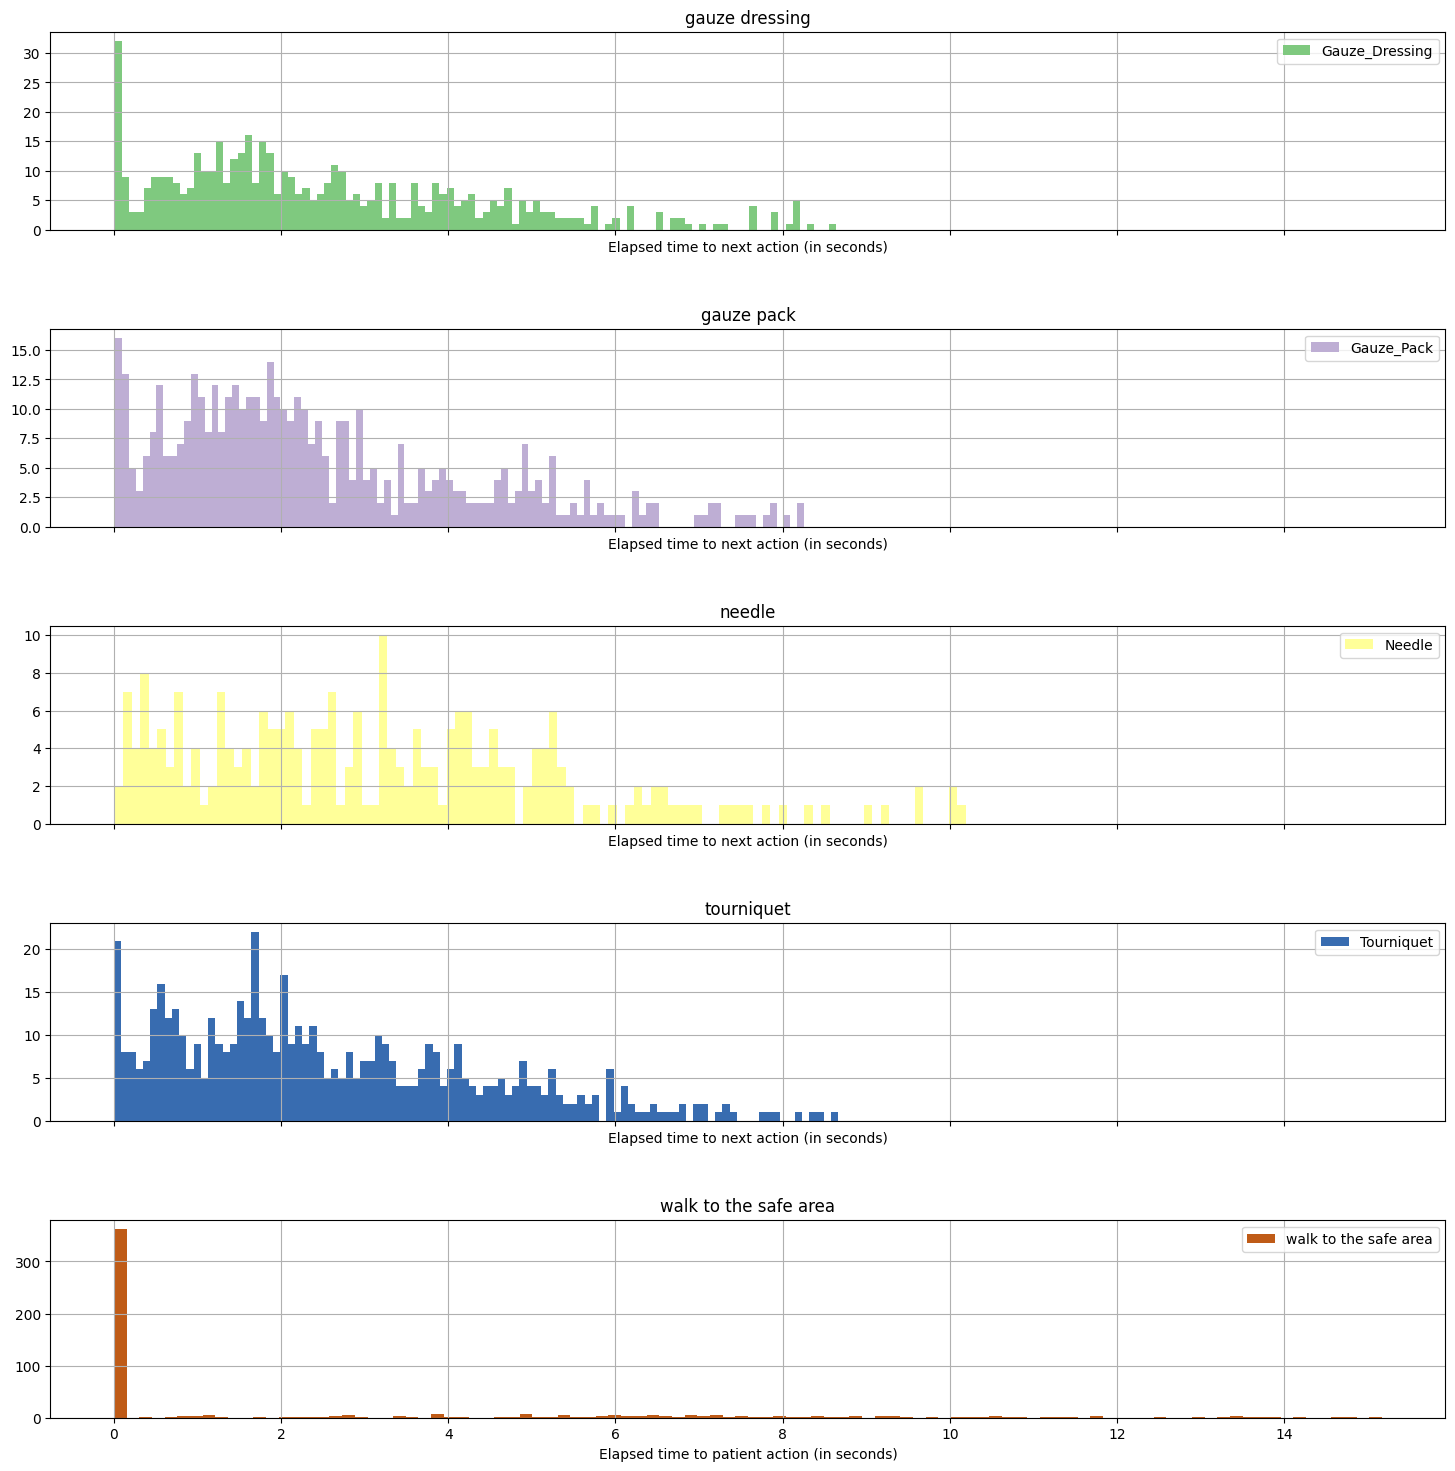

In [22]:

list_length = len(tuples_list)
color_cycler = nu.get_color_cycler(list_length)
fig, axes = plt.subplots(nrows=list_length-1, sharex=True, figsize=(18, 18))
for (i, percentiles_tuple), face_color_dict in zip(enumerate(tuples_list), color_cycler()):
    face_color = face_color_dict['color']
    if i < list_length-1:
        percentiles_tuple[0].hist(ax=axes[i], bins=100, label=percentiles_tuple[1], alpha=1.0, color=face_color)
        axes[i].set_title(percentiles_tuple[1].lower().replace('_', ' '))
    
        # Label the x axis for the plots differently
        if percentiles_tuple[1] in ['walk to the safe area', 'wave if you can']:
            axes[i].set_xlabel('Elapsed time to patient action (in seconds)')
        else:
            axes[i].set_xlabel('Elapsed time to next action (in seconds)')
        
        axes[i].legend()

# Add a larger vertical gap between the plots
plt.subplots_adjust(hspace=0.5)

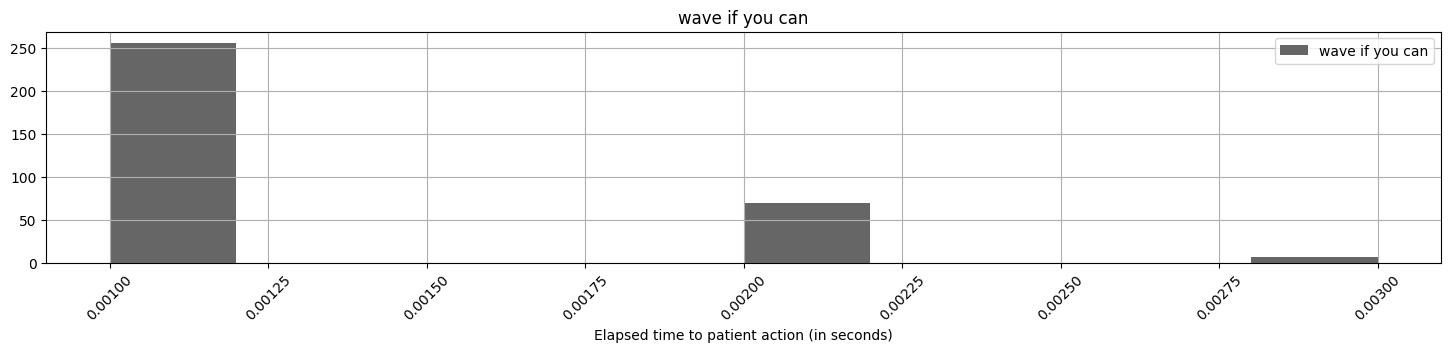

In [23]:

fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(18, 18/6))
tuples_list[-1][0].hist(ax=ax, xrot=45, label=tuples_list[-1][1], alpha=1.0, color=face_color);
ax.set_title(tuples_list[-1][1].lower().replace('_', ' '))

# Label the x axis for the plots differently
ax.set_xlabel('Elapsed time to patient action (in seconds)')

ax.legend();

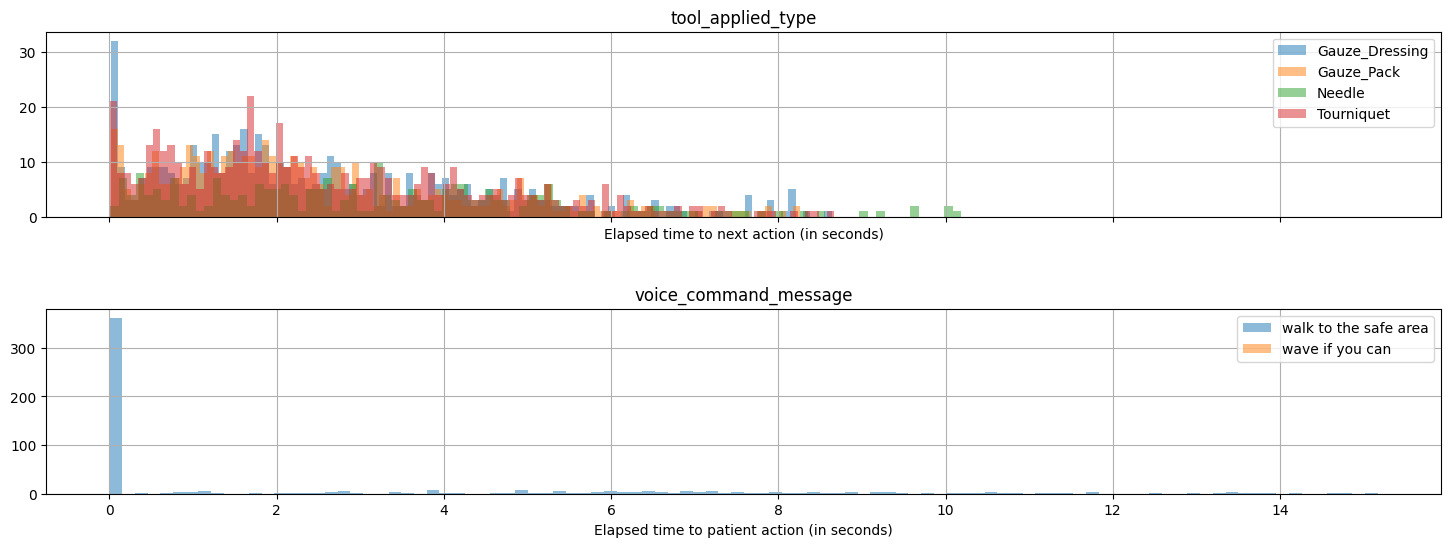

In [152]:

mask_series = ~frvrs_logs_df.delta_to_next_action.isnull()
df = frvrs_logs_df[mask_series]
# print(df.shape)
# display(df.sample(4).dropna(axis='columns', how='all').T)
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(18, 6))
for i, groupby_list in enumerate(['tool_applied_type', 'voice_command_message']):
    for tool_applied_type, df1 in df.groupby(groupby_list):

        # Filter to only keep values within 1.75 * Inter quartile range
        q1 = df1.delta_to_next_action.quantile(0.25)
        q3 = df1.delta_to_next_action.quantile(0.75)
        iqr = q3 - q1
        lower_range = q1 - 1.75 * iqr
        higher_range = q3 + 1.75 * iqr
        mask_series = df1.delta_to_next_action.between(lower_range, higher_range) & ~df1.delta_to_next_action.isnull()
        df_filtered = df1[mask_series]
        
        df_filtered.delta_to_next_action.map(lambda td: td.total_seconds()).hist(ax=axes[i], bins=100, label=tool_applied_type, alpha=0.5)
    axes[i].set_title(groupby_list)
    # axes[i].set_xlim(-1_000, 20_000)

    # Label the x axis for the plots differently
    if i == 1:
        axes[i].set_xlabel('Elapsed time to patient action (in seconds)')
    else:
        axes[i].set_xlabel('Elapsed time to next action (in seconds)')
    
    axes[i].legend()

# Add a larger vertical gap between the plots
plt.subplots_adjust(hspace=0.5)


----

In [56]:

action_type = 'INJURY_TREATED'
mask_series = (frvrs_logs_df.action_type == action_type)
df = frvrs_logs_df[mask_series].sample(4).dropna(axis='columns', how='all')
display(df.T)

125553  \
action_type                                                               INJURY_TREATED   
action_tick                                                                      180555   
event_time                                                           2023-05-31 09:48:00   
session_uuid                                        e96d123b-455b-4335-9278-988ff9ba8ecf   
file_name                                           e96d123b-455b-4335-9278-988ff9ba8ecf   
scene_id                                                                             1   
injury_treated_id                                                     L Thigh Laceration   
injury_treated_patient_id                                                    Mike_1 Root   
injury_treated_required_procedure                                             tourniquet   
injury_treated_severity                                                           medium   
injury_treated_body_region                                                       leftLeg   
injury_treated_injury_treated                                                       True   
injury_treated_injury_treated_with_wrong_treatment                                 False   
injury_treated_injury_injury_locator                                     (2.8, 0.3, 0.3)   
patient_id                                                                   Mike_1 Root   
location_id                                                              (2.8, 0.3, 0.3)   

                                                                                  54003   \
action_type                                                               INJURY_TREATED   
action_tick                                                                      572298   
event_time                                                           2023-05-31 09:24:00   
session_uuid                                        14a344df-eee2-4fd1-b182-e3cdacd9026c   
file_name                                           14a344df-eee2-4fd1-b182-e3cdacd9026c   
scene_id                                                                             2   
injury_treated_id                                                      R Shin Amputation   
injury_treated_patient_id                                                    Lily_2 Root   
injury_treated_required_procedure                                             tourniquet   
injury_treated_severity                                                             high   
injury_treated_body_region                                                      rightLeg   
injury_treated_injury_treated                                                       True   
injury_treated_injury_treated_with_wrong_treatment                                 False   
injury_treated_injury_injury_locator                                     (3.2, 0.1, 4.2)   
patient_id                                                                   Lily_2 Root   
location_id                                                              (3.2, 0.1, 4.2)   

                                                                                  132594  \
action_type                                                               INJURY_TREATED   
action_tick                                                                      592168   
event_time                                                           2023-04-21 09:50:00   
session_uuid                                        f68ce2b4-67dc-4829-89fc-cfe478391148   
file_name                                                                          max11   
scene_id                                                                             2   
injury_treated_id                                                     R Thigh Laceration   
injury_treated_patient_id                                                    Mike_5 Root   
injury_treated_required_procedure                                             tourniquet   
injury_treated_severity                  

In [20]:

f = lambda x: 'air' in str(x).lower()
srs = frvrs_logs_df.applymap(f, na_action='ignore').sum()
mask_series = (srs != 0)
columns_list = srs[mask_series].index.tolist()
if columns_list:
    mask_series = False
    for cn in columns_list:
        mask_series |= frvrs_logs_df[cn].map(f)
    df = frvrs_logs_df[mask_series].sample(4).dropna(axis='columns', how='all')
    display(df.T)

29547   \
action_type                                                               INJURY_RECORD   
action_tick                                                                     189166   
event_time                                                          2023-03-07 10:19:00   
session_uuid                                       33e7d6b6-2868-42e6-8967-d6890efb87a7   
file_name                                                                       Marty11   
scene_id                                                                            2   
injury_record_id                                                          Face Shrapnel   
injury_record_patient_id                                                     Bob_0 Root   
injury_record_required_procedure                                                 airway   
injury_record_severity                                                             high   
injury_record_body_region                                                          head   
injury_record_injury_treated                                                      False   
injury_record_injury_treated_with_wrong_treatment                                 False   
injury_record_injury_injury_locator                                    (-1.6, 1.7, 5.6)   
patient_id                                                                   Bob_0 Root   
location_id                                                            (-1.6, 1.7, 5.6)   

                                                                                 57711   \
action_type                                                               INJURY_RECORD   
action_tick                                                                      25956   
event_time                                                          2023-06-08 10:31:00   
session_uuid                                       2be0000b-9e0b-414f-a540-c495ffc28404   
file_name                                          2be0000b-9e0b-414f-a540-c495ffc28404   
scene_id                                                                            1   
injury_record_id                                                          Face Shrapnel   
injury_record_patient_id                                                    Gary_1 Root   
injury_record_required_procedure                                                 airway   
injury_record_severity                                                             high   
injury_record_body_region                                                          head   
injury_record_injury_treated                                                      False   
injury_record_injury_treated_with_wrong_treatment                                 False   
injury_record_injury_injury_locator                                     (1.6, 1.7, 7.7)   
patient_id                                                                  Gary_1 Root   
location_id                                                             (1.6, 1.7, 7.7)   

                                                                                 10844   \
action_type                                                               INJURY_RECORD   
action_tick                                                                      40233   
event_time                                                          2023-05-22 20:23:00   
session_uuid                                       5fa79a8e-a2df-4bb9-b614-f3ce36a5edb0   
file_name                                          5fa79a8e-a2df-4bb9-b614-f3ce36a5edb0   
scene_id                                                                            1   
injury_record_id                                                          Face Shrapnel   
injury_record_patient_id                                                  Helga_17 Root   
injury_record_required_procedure                                                 airway   
injury_record_severity                                                             h

In [19]:

nasal_regex = re.compile(r'nas(a|o)')
f = lambda x: bool(nasal_regex.search(str(x)))
srs = frvrs_logs_df.applymap(f, na_action='ignore').sum()
mask_series = (srs != 0)
columns_list = srs[mask_series].index.tolist()
if columns_list:
    mask_series = False
    for cn in columns_list:
        mask_series |= frvrs_logs_df[cn].map(f)
    df = frvrs_logs_df[mask_series].sample(4).dropna(axis='columns', how='all')
    display(df.T)

In [11]:

mask_series = (frvrs_logs_df.action_type == 'VOICE_COMMAND') & frvrs_logs_df.voice_command_message.map(lambda x: 'wave' in str(x).lower())
print(frvrs_logs_df[mask_series].shape)
df = frvrs_logs_df[mask_series].sample(4).dropna(axis='columns', how='all')
display(df.T)

(566, 100)


27449   \
action_type                                               VOICE_COMMAND   
action_tick                                                     522330   
event_time                                          2023-03-03 10:31:00   
session_uuid                       e662a811-40fd-4bf2-b9df-d2d221d07b4a   
file_name                                                        Marty1   
scene_id                                                            2   
voice_command_message                                   wave if you can   
voice_command_command_description                                  wave   

                                                                 80204   \
action_type                                               VOICE_COMMAND   
action_tick                                                      28430   
event_time                                          2023-05-11 10:32:00   
session_uuid                       8581c1f8-a4e8-4245-ac73-2bd671237001   
file_name                          8581c1f8-a4e8-4245-ac73-2bd671237001   
scene_id                                                            1   
voice_command_message                                   wave if you can   
voice_command_command_description                                  wave   

                                                                 58693   \
action_type                                               VOICE_COMMAND   
action_tick                                                     233248   
event_time                                          2023-06-23 10:42:00   
session_uuid                       2d920452-cfa3-41f4-95de-36b62a023900   
file_name                          2d920452-cfa3-41f4-95de-36b62a023900   
scene_id                                                            2   
voice_command_message                                   wave if you can   
voice_command_command_description                                  wave   

                                                                 104702  
action_type                                               VOICE_COMMAND  
action_tick                                                      41162  
event_time                                          2023-05-10 11:06:00  
session_uuid                       a1cb9dd5-e62b-4085-99d8-688e0a3856ee  
file_name                          a1cb9dd5-e62b-4085-99d8-688e0a3856ee  
scene_id                                                            1  
voice_command_message                                   wave if you can  
voice_command_command_description     good American wave wave your arms

In [8]:

mask_series = (frvrs_logs_df.action_type == 'TOOL_APPLIED') & frvrs_logs_df.tool_applied_type.map(lambda x: 'gauze' in str(x).lower())
print(frvrs_logs_df[mask_series].shape)
df = frvrs_logs_df[mask_series].sample(4).dropna(axis='columns', how='all')
display(df.T)

(994, 100)


116804  \
action_type                                                         TOOL_APPLIED   
action_tick                                                              302503   
event_time                                                   2023-05-09 09:47:00   
session_uuid                                d347b967-5e20-4527-95dd-3a0fdf73af1d   
file_name                                   d347b967-5e20-4527-95dd-3a0fdf73af1d   
scene_id                                                                     1   
tool_applied_type                                                 Gauze_Dressing   
tool_applied_attachment_point  skinCollider_BodyCollideLOD (UnityEngine.GameO...   
tool_applied_sender                                         AppliedDressingGauze   
tool_applied_patient_id                                              Mike_0 Root   
patient_id                                                           Mike_0 Root   

                                                                          95189   \
action_type                                                         TOOL_APPLIED   
action_tick                                                             1444969   
event_time                                                   2023-05-09 08:34:00   
session_uuid                                9d142377-69d6-4622-958d-a29a6a0a0d21   
file_name                                   9d142377-69d6-4622-958d-a29a6a0a0d21   
scene_id                                                                     3   
tool_applied_type                                                     Gauze_Pack   
tool_applied_attachment_point  skinCollider_BodyCollideLOD (UnityEngine.GameO...   
tool_applied_sender                                          AppliedPackingGauze   
tool_applied_patient_id                                              Mike_5 Root   
patient_id                                                           Mike_5 Root   

                                                                       30685   \
action_type                                                      TOOL_APPLIED   
action_tick                                                           544301   
event_time                                                2023-03-07 10:37:00   
session_uuid                             400b6351-6f35-4f5b-98a6-db100a2fefd8   
file_name                                                             Marty12   
scene_id                                                                  2   
tool_applied_type                                              Gauze_Dressing   
tool_applied_attachment_point  skinCollider_Body_LOD (UnityEngine.GameObject)   
tool_applied_sender                                      AppliedDressingGauze   
tool_applied_patient_id                                         Gloria_6 Root   
patient_id                                                      Gloria_6 Root   

                                                                       68483   
action_type                                                      TOOL_APPLIED  
action_tick                                                           443993  
event_time                                                2023-05-09 08:48:00  
session_uuid                             5aca0157-02d0-4409-a4fe-f64d03fd34a1  
file_name                                5aca0157-02d0-4409-a4fe-f64d03fd34a1  
scene_id                                                                  2  
tool_applied_type                                              Gauze_Dressing  
tool_applied_attachment_point  skinCollider_Body_LOD (UnityEngine.GameObject)  
tool_applied_sender                                      AppliedDressingGauze  
tool_applied_patient_id                                         Gloria_8 Root  
patient_id                                                      Gloria_8 Root

In [26]:

# Get the last previous tool hover for each patient engaged
if nu.pickle_exists('hover_engage_df'):
    hover_engage_df = nu.load_object('hover_engage_df')
else:
    rows_list = []
    for (session_uuid, scene_id), df in fu.get_session_groupby(frvrs_logs_df, mask_series=None, extra_column='scene_id'):
        hover_mask_series = (df.action_type == 'TOOL_HOVER')
        for row_index, row_series in df[hover_mask_series].iterrows():
            hover_elapsed_time = row_series.action_tick
            engage_mask_series = (df.action_tick >= hover_elapsed_time) & ~df.patient_id.isnull()
            if df[engage_mask_series].shape[0]:
    
                # Get the patient's ID
                engage_elapsed_time = df[engage_mask_series].action_tick.min()
                patient_mask_series = (df.action_tick == engage_elapsed_time) & ~df.patient_id.isnull()
                patient_id = df[patient_mask_series].iloc[0].patient_id
    
                # Get the required procedure
                require_mask_series = (df.patient_id == patient_id) & ~df.injury_record_required_procedure.isnull()
                if df[require_mask_series].shape[0]:
                    injury_record_required_procedure = nu.conjunctify_nouns(df[require_mask_series].injury_record_required_procedure.tolist())
                else:
                    injury_record_required_procedure = nan
    
                # Get what tool the DM is looking at
                tool_hover_type = row_series.tool_hover_type
    
                # Add that info to the data frame
                row_dict = {
                    'session_uuid': session_uuid, 'scene_id': scene_id, 'tool_hover_type': tool_hover_type,
                    'injury_record_required_procedure': injury_record_required_procedure, 'patient_id': patient_id
                }
                rows_list.append(row_dict)
    
    
    
    hover_engage_df = DataFrame(rows_list).drop_duplicates(subset=fu.patient_groupby_columns, keep='last')
    
    # Get the last previous tool hover for each patient engaged
    def f(row_series):
        tool_hover_type = str(row_series.tool_hover_type)
        injury_record_required_procedure = str(row_series.injury_record_required_procedure)
        
        if (tool_hover_type.lower() in injury_record_required_procedure):
            similarity = 1.0
        elif (tool_hover_type == 'Tourniquet') and ('tourniquet' not in injury_record_required_procedure):
            similarity = 0.0
        elif (tool_hover_type == 'Hemostatic Gauze') and ('woundpack' in injury_record_required_procedure):
            similarity = 1.0
        elif (tool_hover_type == 'Hemostatic Gauze') and ('woundpack' not in injury_record_required_procedure):
            similarity = 0.0
        elif (tool_hover_type == 'Gauze') and ('gauzePressure' in injury_record_required_procedure):
            similarity = 1.0
        elif (tool_hover_type == 'Gauze') and ('gauzePressure' not in injury_record_required_procedure):
            similarity = 0.0
        elif (tool_hover_type == 'Needle') and ('airway' in injury_record_required_procedure):
            similarity = 1.0
        elif (tool_hover_type == 'Needle') and ('airway' not in injury_record_required_procedure):
            similarity = 0.0
        elif (tool_hover_type != 'NaN') and (injury_record_required_procedure in ['none', 'NaN']):
            similarity = 0.0
        elif (injury_record_required_procedure in ['none', 'NaN']):
            similarity = 1.0
        else:
            similarity = nu.compute_similarity(tool_hover_type, injury_record_required_procedure)
        
        return similarity
    hover_engage_df['similarity'] = hover_engage_df.apply(f, axis='columns')

    # Store the data frame
    nu.store_objects(hover_engage_df=hover_engage_df)

In [42]:

percent_accuracy = 100*hover_engage_df.similarity.sum()/hover_engage_df.similarity.shape[0]
print(
    'The last previous tool hover correctly anticipates the required injury procedure for each patient engaged'
    f' {percent_accuracy:.1f}% of the time.')

The last previous tool hover correctly anticipates the required injury procedure for each patient engaged 65.5% of the time.
